In [1]:

from typing import Sequence, Tuple, Union, Optional, Callable, Literal, Protocol
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike


import jax
from jax import grad, jit, vmap
import jax.numpy as jnp
from jax import random as jrandom
import equinox as eqx

import optax


from functools import partial

from collections.abc import Generator
from typing_extensions import TypeAlias



from dataclasses import dataclass, asdict, astuple

# Utils

In [2]:
class Range(eqx.Module):
    minval: float = 0.0
    maxval: float = 1.0

class ModelState(eqx.Module):
    S0: float
    v0: float

In [3]:
import matplotlib.pyplot as plt

def plot_differential_data(init_spots, init_vols, payoffs, states: ModelState):
    # plt.plot(init_spots, payoffs, 'b.', markersize=1.0, label = 'payoffs')
    plt.plot(init_spots, states.S0, 'r.', markersize=1.0, label = 'dpayoff/dS0')

    print(init_spots.shape)
    print(states.S0.shape)
    # plt.plot(init_spots, states
    # plt.plot(hset.initial_spot_prices, prices, 'r.', markersize=3, label='price')
    plt.legend()
    plt.xlabel('initial spot price')
    plt.ylabel('payoff')
    # plt.ylim(-1, 1000)
    plt.show()

def plot_3d_differential_data(init_spots, init_vols, differential_data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(init_spots, init_vols, differential_data, c=differential_data, cmap=plt.cm.viridis)
    
    # Add a colorbar to show the mapping of colors to z-values
    cbar = fig.colorbar(sc)
    cbar.set_label(label)
    
    ax.set_title(label)
    ax.set_xlabel("$S_0$")
    ax.set_ylabel("\nu_0")
    ax.set_zlabel(label)
    return fig


In [4]:
def mse(y_pred, y_true):
    return jnp.mean((jnp.array(y_pred) - jnp.array(y_true))**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))


# HVP stuff

In [11]:

# HVP for single point and single direction from Bachelier
def hvp(f, x, v):
    return jax.jvp(lambda x_: eqx.filter_grad(f)(x_), (x,), (v,))[1]

# from bachelier
def hvp_batch(f, inputs, directions):
    """
    Compute Hessian-vector products: H(x_i) @ v_j
    Args:
        f: scalar-valued function f: R^n -> R
        inputs: [num_inputs, input_dim]
        directions: [num_directions, input_dim]
    Returns:
        hvps: [num_inputs, num_directions, input_dim]
    """
    def hvp_fn(x, v):
        return hvp(f, x, v)
    batched = eqx.filter_vmap(eqx.filter_vmap(hvp_fn, in_axes=(0, None)), in_axes=(None, 0))
    return jnp.transpose(batched(inputs, directions), (1, 0, 2))




# Payoff

In [5]:
class EuropeanPayoff:

    # TODO: naming: strike_prices should be strike_price unless we would like to support an array of strike prices
    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(maturity_prices, strike_prices), 0.0)

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(strike_prices, maturity_prices), 0.0)

    @staticmethod
    def payoff(spot_path, K, payoff_fn = call):
        spot_maturity = spot_path[..., -1]
        payoff = payoff_fn(spot_maturity, K)
        return payoff


def european_payoff(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    payoff = payoff_fn(spot_maturity, K)
    return payoff

def european_payoff_and_deriv(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    # payoff = payoff_fn(spot_maturity, K)
    payoff, dpayoff = jax.value_and_grad(payoff_fn)(spot_maturity, K)
    return payoff, dpayoff

In [6]:
sharpness = 1e-3
bias = sharpness

def smooth_european_payoff(x, k):
    return jax.nn.celu(x=x-k, alpha=sharpness) + bias


fn = lambda x: jax.nn.celu(x=x, alpha=sharpness) + bias
smooth_max_fn = fn


# Heston

In [46]:
#class ModelState(eqx.Module):
#    S0: float
#    v0: float

# just for testing
class DDModelState(eqx.Module):
    S0: ModelState
    v0: ModelState

    
class Heston(eqx.Module):

    ## the state of the model at any given 
    #class State(eqx.Module):
    #    S0: float
    #    v0: float
        
    ## European call option price is at 34.99 for the following config: 
    #class Parameters(eqx.Module):
    #    K: float = 100.0        # Strike price
    #    r: float = 0.05         # Risk-free rate
    #    T: float = 5.0          # n years until expiry, i.e. T2 - T1
    #    rho: float = -0.3       # Correlation of asset and volatility
    #    kappa: float = 2.00     # Mean-reversion rate
    #    theta: float = 0.09     # Long run average volatility
    #    xi: float = 1.00        # Volatility of volatility

    
    #S0: float = 100.0       # Initial spot price
    #v0: float = 0.09        # Initial volatility

    spot_range:Range = Range(50.0, 150.0)
    vol_range: Range = Range(0.01, 0.1)
     
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    T: float = 5.0          # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility

    #@classmethod
    #def from_parameters(cls, parameters: Parameters, **kwargs):
    #    return cls(*astuple(parameters), **kwargs)
    
    #@property
    #def model_state(self) -> ModelState:
    #    return ModelState(self.S0, self.v0)


    def volatility_path(self, vol_draws, v0: float):
        n_steps = len(vol_draws)
        dt = self.T / n_steps

        def vol_path_iter(prev_vol_path, vol_draw):
            # v_truncated = smooth_max_cubic(prev_vol_path)
            v_truncated = smooth_max_fn(prev_vol_path)
            prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
            randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
            current = prev_path_contribution + randomness
            return current, current # use current both for carry and for y

        carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(v0), vol_draws, length=n_steps)

        # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
        vol_path = jnp.roll(vol_path.at[-1].set(v0), 1)
        return vol_path



    def spot_path(self, spot_draws: Array, vol_path: Array, S0:float) -> Array:
        n_steps = len(spot_draws)
        dt = self.T / n_steps

        def spot_path_iter(prev_spot_path, iter_pair):
            spot_draw = iter_pair[0]
            vol = iter_pair[1]
            # v_truncated = smooth_max_cubic(vol)
            v_truncated = smooth_max_fn(vol)
            path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
            return path_new_spot, path_new_spot

        iter_values = jnp.column_stack((spot_draws, vol_path))
        carry, spot_paths = jax.lax.scan(spot_path_iter, jnp.array(S0), iter_values, length=n_steps)

        # we now have iteration 1 at position 0. Place initial S0 at the end and rotate into initial slot
        spot_paths = jnp.roll(spot_paths.at[-1].set(S0), 1)
        return spot_paths


    def payoff(self, spot_path):
        spot_maturity = spot_path[-1] # taking only the last element is specific to the european payoff
        # smooth_payoff_fn = cubic_spline_smoothing(payoff_fn)
        smooth_payoff_fn = smooth_european_payoff
        # TODO pass strike price K
        payoff = smooth_payoff_fn(spot_maturity, 100.0) #self.K)
        return payoff

    #def model_state_path(self, vol_draws, spot_draws, S0, v0):
    #    vol_path = self.volatility_path(vol_draws, v0)
    #    s_path = self.spot_path(spot_draws, vol_path, S0)
    #    return s_path
    
    #def path_and_payoff(self, vol_draws, spot_draws, S0, v0):
    #    vol_path = self.volatility_path(vol_draws, v0)
    #    spot_path = self.spot_path(spot_draws, vol_path, S0)
    #    # (n_time_steps,)
    #    return self.payoff(spot_path)

    @eqx.filter_jit
    def correlated_draws(self, path_seed, n_samples: int):
        mean = jnp.zeros(2)
        cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])

        correlated_samples = jrandom.multivariate_normal(path_seed, mean, cov, shape=(n_samples,))
        vol_draws = correlated_samples[:, 0]
        spot_draws = correlated_samples[:, 1]
        return vol_draws, spot_draws

    #def path(self: Heston, key: PRNGKeyArray, n_time_steps: int = 1024):
    #    vol_draws, spot_draws = correlated_draws(self, key, n_time_steps)
    #    return path_and_payoff(self, vol_draws, spot_draws)

    diff_payoff_fn = eqx.filter_grad(payoff)

    def path_and_payoff(self, path_seed, n_time_steps, S0, v0):
        # sample noise steps for the path
        vol_draws, spot_draws = self.correlated_draws(path_seed, n_time_steps)
        # build path
        vol_path  = self.volatility_path(vol_draws, v0)
        spot_path = self.spot_path(spot_draws, vol_path, S0)
        # get payoff
        return self.payoff(spot_path)



    def new_differential_path(self, path_seed, n_time_steps, S0, v0):
        
        # TODO make cleaner, less nesting

        def f_s0_v0(s0, v0):
            return self.path_and_payoff(path_seed, n_time_steps, s0, v0)

        y, (dS0, dV0) = jax.value_and_grad(f_s0_v0, argnums=(0,1))(S0, v0)

        return y, jnp.array([dS0, dV0])
    


    
    def hessian_2x2_for_one(self, initial_spots, initial_vols, path_seed):
        def f_s0v0(x):
            s0, v0 = x
            return self.path_and_payoff(
                path_seed, 
                n_time_steps=1024,
                S0=s0, 
                v0=v0
            )
        
        hvps = hvp_batch(
            f=f_s0v0,
            # NOTE this is where later the extra basket dim can be added
            inputs=jnp.array([(initial_spots, initial_vols)]), 
            directions=jnp.array([[1.0, 0.0], [0.0, 1.0]]) 
        )
        
        H_block = jnp.transpose(hvps[0], (1,0))

        return H_block


    




    def sample_training_batch(self, key, batch_size=256):    
        # TODO normalization?

        key, key_state = jrandom.split(key)
        
        minvals=jnp.array([self.spot_range.minval, self.vol_range.minval])
        maxvals=jnp.array([self.spot_range.maxval, self.vol_range.maxval])
        
        initial_states = jrandom.uniform(key_state, shape=(batch_size, 2), minval=minvals, maxval=maxvals)
        initial_spots = initial_states[:, 0]
        initial_vols = initial_states[:, 1]

        path_seeds = jrandom.split(key, batch_size)



        # TODO make cleaner, less nesting
        def fn(path_seed, S0, v0):
            return self.new_differential_path(path_seed, n_time_steps=1024, S0=S0, v0=v0)
        y, dydx = jax.vmap(fn)(path_seeds, initial_spots, initial_vols)

        #print("x shape: ", initial_states.shape) # (batch_size, 2)
        #print("y shape: ", y.shape) # (batch_size,)
        #print("dydx shape: ", dydx.shape) # (batch_size, 2)



        

        #ddps = eqx.filter_vmap(partial(hessian_path, n_time_steps=1024))(hs, path_seeds)

        #ddps = eqx.filter_vmap(partial(hvp_s_path, n_time_steps=1024))(hs, path_seeds)
        
        
        # TODO reuse path_seed for every tangent we evaluate a primal in
        # So that only the effect of directional perturbation is in hvp result, not effect of different noise



        #ddyddx = jax.vmap(self.hessian_2x2_for_one, in_axes=(0, 0, 0))(initial_spots, initial_vols, path_seeds)        
        
        ddyddx = None

        #print("ddyddx shape: ", ddyddx.shape) # (batch_size, 2, 2)






        #ddps = DDModelState(S0=ModelState(S0=0, v0=0), 
        #                    v0=ModelState(S0=0, v0=0))





        #dps = jnp.stack([dps.S0, dps.v0], axis=-1)
        # (256, 2)
        #ddps = jnp.stack([
        #    jnp.stack([ddps.S0.S0, ddps.S0.v0], axis=-1),
        #    jnp.stack([ddps.v0.S0, ddps.v0.v0], axis=-1)
        #], axis=-2)
        # (256, 2, 2)


        #dps = {"S0": dps.S0, "v0": dps.v0} 
        #ddps = {"S0": { "S0": ddps.S0.S0, 
        #                "v0": ddps.S0.v0},
        #        "v0": { "S0": ddps.v0.S0,
        #                "v0": ddps.v0.v0}}  

        #print("x shape: ", initial_states.shape)
        #print("y shape: ", ps.shape)
        #print("dydx: ", dps)
        #print("ddyddx: ", ddps)

        return initial_states, y, dydx, ddyddx
        #      x               y   dydx ddy

        ##initial_states, ps, dps, ddps
        ##x, y, dydx, ddy


diff hvp stuff

old hvp stuff

In [9]:
def old_differential_path(hs: Heston, path_seed: PRNGKeyArray, n_time_steps: int = 1024):
    vol_draws, spot_draws = correlated_draws(hs, path_seed, n_time_steps)
    # (1024,), (1024,)
    return eqx.filter_value_and_grad(path_and_payoff)(hs, vol_draws, spot_draws)


def old_hessian_path(self: Heston, key: PRNGKeyArray, n_time_steps: int = 1024):
    vol_draws, spot_draws = correlated_draws(self, key, n_time_steps)
    return jax.hessian(path_and_payoff)(self, vol_draws, spot_draws)



def old_hvp(f, primals, tangents):
    #return eqx.filter_jvp(eqx.filter_grad(f), primals, tangents)[1]
    res = eqx.filter_jvp(eqx.filter_grad(f), primals, tangents)
    print("res:", res)
    # TODO here the result is tuple (Heston, Heston) 
    #              opposed to shape (batch_size, 2)

    return jnp.array(res)
    
def old_hvp_path(self: Heston, key: PRNGKeyArray, h_tangent: Heston, n_time_steps: int=1024):
    vol_draws, spot_draws = correlated_draws(self, key, n_time_steps)
    # TODO need to draw these once BEFORE 
    # (n_time_steps, ), (n_time_steps, )
    return old_hvp(partial(path_and_payoff, vol_draws=vol_draws, spot_draws=spot_draws), (self, ), (h_tangent, ))

hvp_s_path = partial(old_hvp_path, h_tangent= Heston(
        S0 = 1.0,       
        K = 0.0,   
        r = 0.00,
        v0 = 0.0, 
        T = 0.0,
        rho = 0.0,
        kappa = 0.0,
        theta = 0.0,
        xi = 0.0,
    ))

hvp_v_path = partial(old_hvp_path, h_tangent= Heston(
        S0 = 0.0,       
        K = 0.0,   
        r = 0.00,
        v0 = 1.0, 
        T = 0.0,
        rho = 0.0,
        kappa = 0.0,
        theta = 0.0,
        xi = 0.0,
    ))


# Dataset

In [9]:
class HestonDataset(eqx.Module):
    initial_states: Array
    payoffs: Array
    differentials: ModelState
    
    def as_flattened_dict(self):
        d = asdict(self)

        d["payoffs"] = jnp.ravel(d["payoffs"])
        d["initial_states"] = jnp.reshape(d["initial_states"], (-1, d["initial_states"].shape[-1]))
        d["differentials"] = jnp.stack(jax.tree_util.tree_flatten(jax.tree_util.tree_map(jnp.ravel, d["differentials"]))[0], axis=1)
        return d

    def metadata(self, spot_range: Range, vol_range: Range):
        return {"spot_range": asdict(spot_range), "vol_range": asdict(vol_range), "n_samples": self.payoffs.size}


def data_set_precomputed(params: Heston.Parameters, *, key: PRNGKeyArray, spot_range: Range, vol_range: Range, is_test=False) -> HestonDataset:

    minvals=jnp.array([spot_range.minval, vol_range.minval])
    maxvals=jnp.array([spot_range.maxval, vol_range.maxval])

    def data_set_precomputed_inner(carry, key):
        n_inner_paths = 2**13
        key, key_state = jrandom.split(key, 2)

        
        if is_test:
            # IF TEST
            initial_states = jnp.ones((n_inner_paths, 2)) * jrandom.uniform(key_state, shape=(2,), minval=minvals, maxval=maxvals)
        else:
            # IF TRAIN
            initial_states = jrandom.uniform(key_state, shape=(n_inner_paths, 2), minval=minvals, maxval=maxvals)
        
        

        initial_spots = initial_states[:, 0]
        initial_vols = initial_states[:, 1]
        
        # initial_spots = jnp.ones(n_inner_paths) * 100.0
        # initial_vols = jnp.ones(n_inner_paths) * 0.09    
        
        hs = Heston.from_parameters(params, S0=initial_spots, v0=initial_vols)
        
        path_seeds = jrandom.split(key, n_inner_paths)
        ps, dps = eqx.filter_vmap(partial(differential_path, n_time_steps=1024))(hs, path_seeds)
        
        return carry+1, HestonDataset(initial_states, ps, dps)
    

    # due to limited vram of gpu we need to split up the computation into outer and inner paths.
    n_outer_paths = 2**6
    key, subkey = jrandom.split(key)
    key_rngs = jrandom.split(subkey, n_outer_paths)
    carry, dataset = jax.lax.scan(data_set_precomputed_inner, 0, key_rngs)
    

    # TODO understand why only for test?
    if is_test:

        def discounted_avg(x, h: Heston.Parameters):
            return jnp.mean(x, axis=1) * jnp.exp(-h.r * h.T) 
        
        # TODO there goes something wrong here, where differentials is not of type ModelState
        #jax.debug.print("test set {}", dataset)
        
        dataset = HestonDataset(*astuple(jax.tree_util.tree_map(partial(discounted_avg, h=params), dataset)))

        # TODO there goes something wrong here, where differentials is still not of type ModelState
        #jax.debug.print("test set after {}", dataset)
        

    return dataset

AttributeError: type object 'Heston' has no attribute 'Parameters'

plot

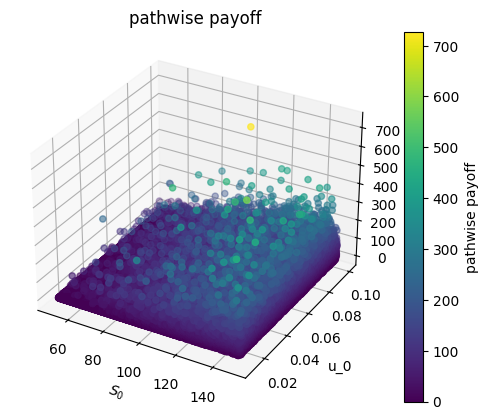

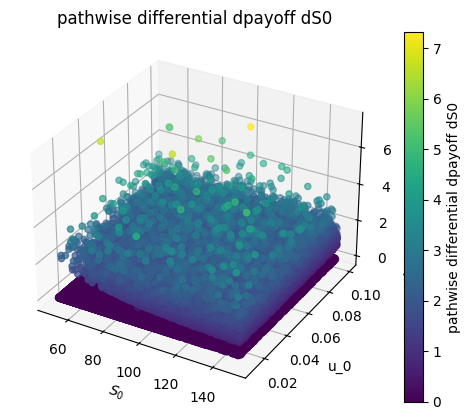

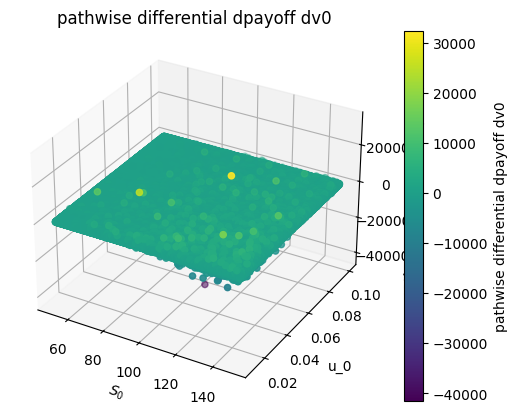

In [10]:
ds = data_set_precomputed(params=hs_params, key=key, spot_range=spot_range, vol_range=vol_range, is_test=False)

xs = ds.initial_states[..., 0]
ys = ds.initial_states[..., 1]

fig_payoff = plot_3d_differential_data(xs, ys, ds.payoffs, "pathwise payoff")
fig_dS = plot_3d_differential_data(xs, ys, ds.differentials.S0, "pathwise differential dpayoff dS0")
fig_dv = plot_3d_differential_data(xs, ys, ds.differentials.v0, "pathwise differential dpayoff dv0")

In [ ]:
# Training batch old


def old_training_batch(spot_range, vol_range, hs_params, key, batch_size=256):    

    minvals=jnp.array([spot_range.minval, vol_range.minval])
    maxvals=jnp.array([spot_range.maxval, vol_range.maxval])

    key, key_state = jrandom.split(key)

    initial_states = jrandom.uniform(key_state, shape=(batch_size, 2), minval=minvals, maxval=maxvals)
    initial_spots = initial_states[:, 0]
    initial_vols = initial_states[:, 1]

    hs = Heston.from_parameters(hs_params, S0=initial_spots, v0=initial_vols)
    path_seeds = jrandom.split(key, batch_size)

    ps, dps = eqx.filter_vmap(partial(old_differential_path, n_time_steps=1024))(hs, path_seeds)
    ddps = eqx.filter_vmap(partial(old_hessian_path, n_time_steps=1024))(hs, path_seeds)
    
    print("x shape: ", initial_states.shape)
    print("y shape: ", ps.shape)
    print("dydx: ", dps)
    print("ddyddx: ", ddps)

    
    # Extracting the S0 and v0 components from the weird Heston classes
    # TODO find out where the Heston classes come from and get rid of it
    dps = jnp.stack([dps.S0, dps.v0], axis=-1)
    # (256, 2)
    ddps = jnp.stack([
        jnp.stack([ddps.S0.S0, ddps.S0.v0], axis=-1),
        jnp.stack([ddps.v0.S0, ddps.v0.v0], axis=-1)
    ], axis=-2)
    # (256, 2, 2)


    #dps = {"S0": dps.S0, "v0": dps.v0} 
    #ddps = {"S0": { "S0": ddps.S0.S0, 
    #                "v0": ddps.S0.v0},
    #        "v0": { "S0": ddps.v0.S0,
    #                "v0": ddps.v0.v0}}  
    
    #print("x shape: ", initial_states.shape)
    #print("y shape: ", ps.shape)
    #print("dydx: ", dps)
    #print("ddyddx: ", ddps)

    return initial_states, ps, dps, ddps
    #      x               y   dydx ddy

    ##initial_states, ps, dps, ddps
    ##x, y, dydx, ddy


In [59]:
key = jrandom.PRNGKey(0)

ref_model = Heston(
    spot_range = Range(50.0, 150.0),
    vol_range = Range(0.01, 0.1),
    K= 100.0,
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0
)




# using hessian_path(): 1.1s for batch_size=256
# using 0:              0.2, 0.4s
# using hvp:
# using cfd:

#vis_batch = old_training_batch(spot_range, vol_range, hs_params, key, batch_size=256)#8196)
new_vis_batch = ref_model.sample_training_batch(key, batch_size=256)#8196)


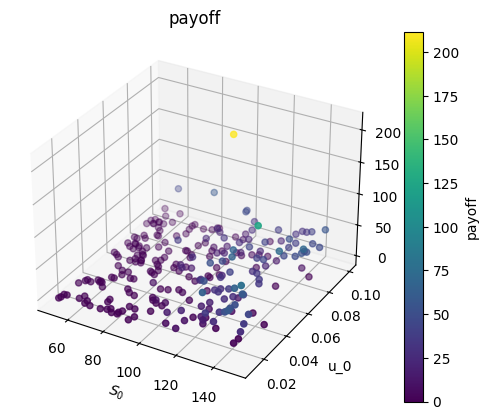

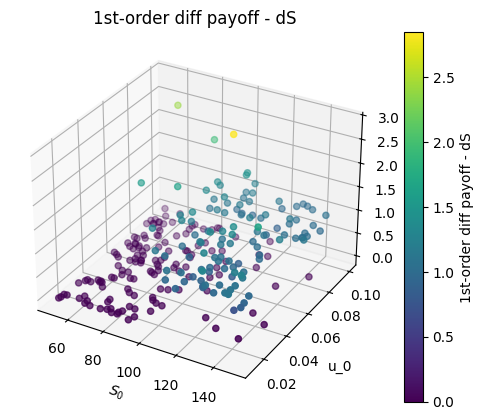

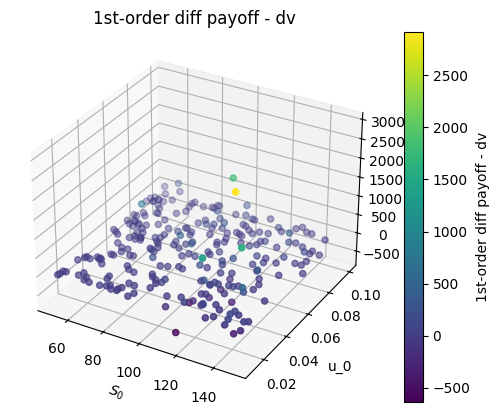

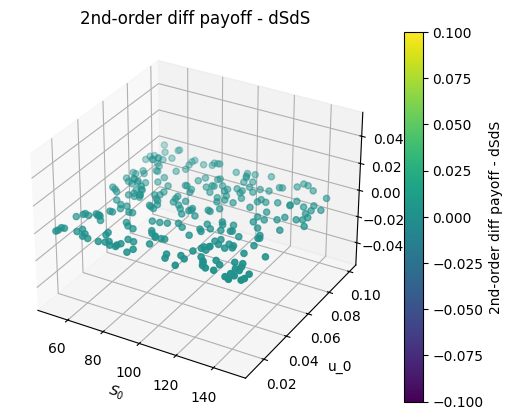

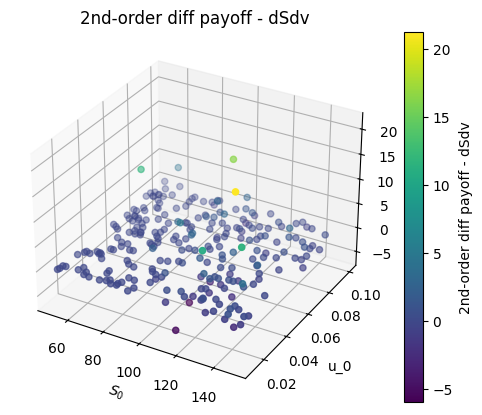

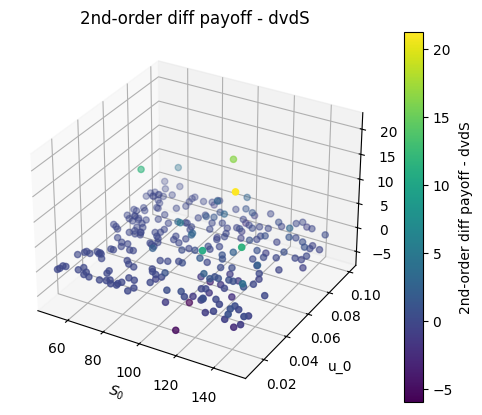

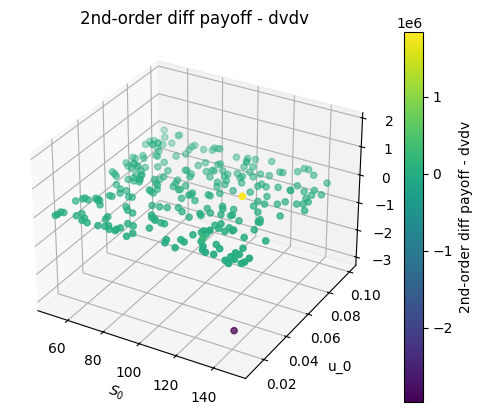

In [30]:
xs = new_vis_batch[0][..., 0]
ys = new_vis_batch[0][..., 1]

ps = new_vis_batch[1]
dps = new_vis_batch[2]
ddps = new_vis_batch[3]

fig_payoff = plot_3d_differential_data(xs, ys, ps, "payoff")

fig_dS = plot_3d_differential_data(xs, ys, dps[:, 0], "1st-order diff payoff - dS")
fig_dv = plot_3d_differential_data(xs, ys, dps[:, 1], "1st-order diff payoff - dv")

fig_dS = plot_3d_differential_data(xs, ys, ddps[:, 0, 0], "2nd-order diff payoff - dSdS")
fig_dv = plot_3d_differential_data(xs, ys, ddps[:, 0, 1], "2nd-order diff payoff - dSdv")
fig_dS = plot_3d_differential_data(xs, ys, ddps[:, 1, 0], "2nd-order diff payoff - dvdS")
fig_dv = plot_3d_differential_data(xs, ys, ddps[:, 1, 1], "2nd-order diff payoff - dvdv")


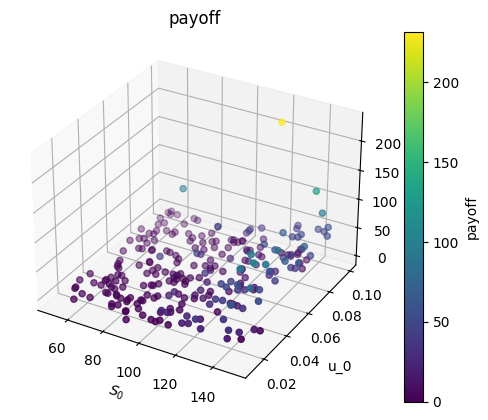

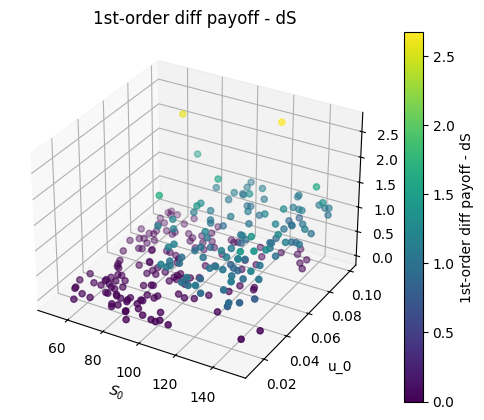

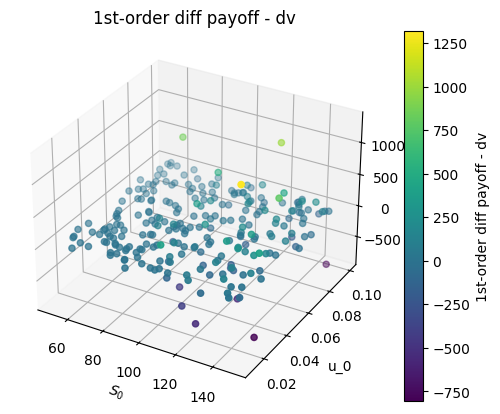

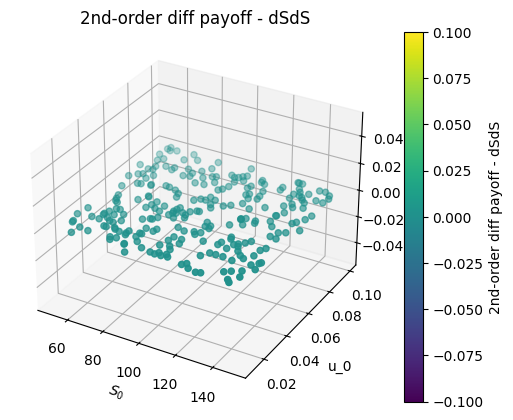

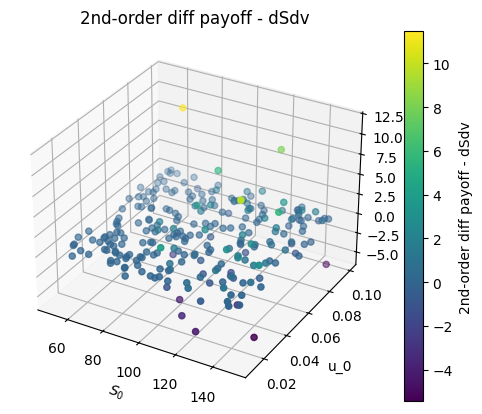

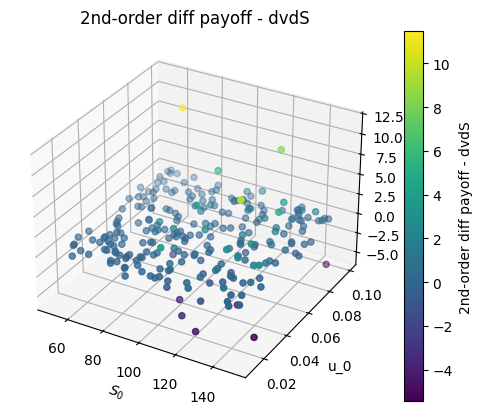

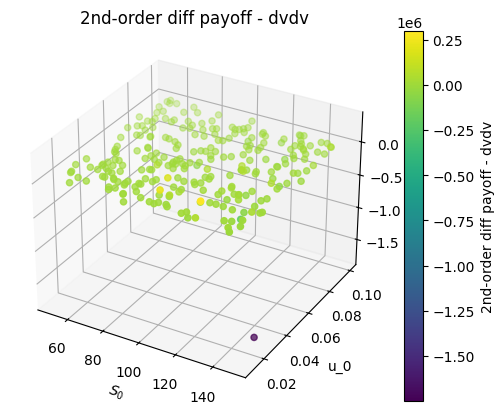

In [ ]:
# old for reference
xs = vis_batch[0][..., 0]
ys = vis_batch[0][..., 1]

ps = vis_batch[1]
dps = vis_batch[2]
ddps = vis_batch[3]

fig_payoff = plot_3d_differential_data(xs, ys, ps, "payoff")

fig_dS = plot_3d_differential_data(xs, ys, dps[0], "1st-order diff payoff - dS")
fig_dv = plot_3d_differential_data(xs, ys, dps[1], "1st-order diff payoff - dv")

fig_dS = plot_3d_differential_data(xs, ys, ddps[0][0], "2nd-order diff payoff - dSdS")
fig_dv = plot_3d_differential_data(xs, ys, ddps[0][1], "2nd-order diff payoff - dSdv")
fig_dS = plot_3d_differential_data(xs, ys, ddps[1][0], "2nd-order diff payoff - dvdS")
fig_dv = plot_3d_differential_data(xs, ys, ddps[1][1], "2nd-order diff payoff - dvdv")


# Standard ML

### Model

In [ ]:
#Model = Callable[[Array, Optional[PRNGKeyArray]], Array]
#
#
#class Normalization(eqx.Module):
#    """Preprocessing layer to receive normalized input.
#
#    Similar to `Normalization` layer of Keras.
#    """
#
#    mean: Float[Array, ""]
#    std: Float[Array, ""]
#
#    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
#        res = (x - self.mean) / self.std
#        # jax.debug.print("normalized x is: {}", res)
#        return res
#
#class Denormalization(eqx.Module):
#    """Preprocessing layer to denormalize data to original scale."""
#
#    mean: Float[Array, ""]
#    std: Float[Array, ""]
#
#    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
#        res = x * self.std + self.mean
#        # jax.debug.print("normalized y was: {}", x)
#        # jax.debug.print("denormalized y is: {}", res)
#        return res
#
#class Normalized(eqx.Module):
#    seq: eqx.nn.Sequential
#
#    def __init__(
#        self,
#        x_normalizer: Normalization,
#        model: eqx.Module,
#        y_denormalizer: Denormalization,
#    ):
#        self.seq = eqx.nn.Sequential(layers=(x_normalizer, model, y_denormalizer))
#
#    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
#        return self.seq(x, key=key)

In [31]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model

### Loss Functions

In [48]:
def standard_loss_fn(model, batch):
    x = batch[0]
    y = batch[1]
    y_pred = vmap(model)(x)
    return mse(y, y_pred)


@eqx.filter_jit
def second_order_loss_fn(model: eqx.nn.MLP, batch, key: PRNGKeyArray) -> Float:

    x = batch[0]
    y = batch[1]
    dydx = batch[2]
    ddyddx = batch[3]

    #print("x shape: ", x.shape)
    #print("y shape: ", y.shape)
    #print("dydx shape: ", dydx.shape)
    #print("ddyddx shape: ", ddyddx.shape)
    #print("")
    #return .0


    # TODO normalization ?
    #x = (x - x_mean) / x_std
    #y = (y - y_mean) / y_std
    
    # TODO loss balancing
    #lam = 1
    #n_dims = model.in_size
    #lambda_scale = lam * n_dims
    #alpha = 1.0/(1.0 + lambda_scale)
    #beta = lambda_scale/(1.0 + lambda_scale)
    #gamma = 0.0

    alpha = 1/3
    beta = 1/3
    gamma = 1/3
    
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(model))(x)
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    
    #print("y_pred shape: ", y_pred.shape)
    #print("dydx_pred shape: ", dydx_pred.shape)
    #print("")
    #return .0

    #def model_hvp(x):
    #    return hvp(model, (x, ), (jnp.ones_like(x), ))
    ##ddyddx_pred = eqx.filter_vmap(model_hvp)(x)
    ## ddy_pred = eqx.filter_vmap(jax.hessian(model))(x)
    ddyddx_pred = ddyddx
    #assert(ddyddx_pred.shape == ddyddx.shape)
    
    #print("ddyddx_pred shape: ", ddyddx_pred.shape)
    #print("")
    #return .0

    # TODO some weird scaling???
    #dydx_array = jnp.stack((dydx.S0, dydx.v0), axis=1)
    #dydx_scaled = (x_std / y_std) * dydx_array 
    # jax.debug.print("delta dydx-scaled: {}", dydx_scaled - ((x_std/y_std) * dydx_array))
    #only_S0 = True
    #if only_S0:
    #    ddy_scaled = (x_std[0]**2 / y_std) * ddy.S0.S0
    #else:    
    #    ddy_array = jnp.stack((ddy.S0.S0, ddy.S0.v0, ddy.v0.S0, ddy.v0.v0), axis=1)
    #    ddy_array = jnp.reshape(ddy_array, ddy_pred.shape)
    #    ddy_scaled = (jnp.outer(x_std, x_std) / y_std) * ddy_array
    #    print(ddy_scaled)


    value_loss = mse(y_pred, y)
    grad_loss = mse(dydx_pred, dydx) 
    #hess_loss = mse(ddyddx_pred, ddyddx)
    hess_loss = 0
    
    #value_loss = jnp.mean((y_pred - y)**2)
    #grad_loss = jnp.mean(lambda_j**2 * (dydx_pred - dydx_scaled)**2)
    
    # TODO more weird scaling???
    #if only_S0:
    #    hess_loss = jnp.mean(lambda_jj * (ddy_pred[:, 0] - ddy_scaled) ** 2)
    #else:
    #    hess_loss = jnp.mean((ddy_pred[:, 0] - ddy_scaled[:, 0]) ** 2)
    
    loss = alpha * value_loss + beta * grad_loss + gamma * hess_loss

    return loss




### Train

In [49]:
from itertools import islice

Data: TypeAlias = dict[str, Float[Array, "n_samples ..."]]
DataGenerator: TypeAlias = Generator[Data, None, None]


def train(
    model: PyTree,
    test_data: Optional[Data],
    optim: optax.GradientTransformation,
    n_epochs: int,
    n_batches_per_epoch: int,
    batch_size: int,
    key: PRNGKeyArray,
) -> PyTree:
    @eqx.filter_jit
    def train_step(model: PyTree, opt_state: PyTree, batch):
        
        #loss_value, grads = eqx.filter_value_and_grad(standard_loss_fn)(model, batch)
        loss_value, grads = eqx.filter_value_and_grad(second_order_loss_fn)(model, batch, key)
        
        
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    train_loss = jnp.zeros(1)

    n_steps = n_epochs * n_batches_per_epoch
    print(f"Training for {n_epochs} epochs with {n_batches_per_epoch} batches per epoch and batch size {batch_size}.")
    
    keys = jrandom.split(key, n_steps)

    for i, key in enumerate(keys):
        
        batch = ref_model.sample_training_batch(key, batch_size)
        
        
        # print(i)
        # print(batch["normalized_initial_states"])
        # print(batch["normalized_payoffs"].shape)
        with jax.profiler.StepTraceAnnotation("Train Step", step_num=i):  

            model, opt_state, train_loss = train_step(model, opt_state, batch)
        
        if i % n_batches_per_epoch == 0:
            epoch_stats = f"Finished epoch {int(i/n_batches_per_epoch)+1} | Train Loss: {train_loss:.5f}"    
            print(epoch_stats)

        # TODO test data evaluation
        #if test_data:
        #    test_loss = evaluate(model, test_data, batch_size, eval_fn)
        #    metrics_update_element(metrics, "test_loss", epoch, test_loss)
        #    epoch_stats += f" | Test: {test_loss:.5f}"
        
        
        
        # def train_inner(model, opt_state, train_loss):
        #     batch = next(train_data)
        #     model, opt_state, train_loss = train_step(model, opt_state, batch)
    
        #     if i % n_steps_per_epoch == 0:
        #         epoch_stats = f"Finished epoch {i:3d} | Train Loss: {train_loss:.5f}"    
        #         print(epoch_stats)
    
        #     return model, opt_state, train_loss
        
        # model = jax.lax.fori_loop(0, n_steps, train_inner, (model, opt_state, train_loss))
    
    return model

In [50]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

# in_size is 2 for initial_spot and initial_vol
n_dims = 2
mlp = eqx.nn.MLP(key=subkey, in_size=n_dims, out_size="scalar", width_size=20, depth=3, activation=jax.nn.elu)

key, subkey = jax.random.split(key)
mlp = init_linear_weight(mlp, trunc_init, key)
surrogate_model = mlp

In [60]:
n_epochs = 100 # 100
n_batches_per_epoch = 32
BATCH_SIZE = 256 # 256

key = jrandom.PRNGKey(0)

ref_model = Heston(
    spot_range = Range(50.0, 150.0),
    vol_range = Range(0.01, 0.1),
    K= 100.0,
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0
)


#train_dataset = ds
#generator_train_ds = generator_train_data(train_dataset, batch_size=BATCH_SIZE)
#generator_test_ds = None
# total_steps = n_epochs * (len(ds["payoffs"]) // BATCH_SIZE) + n_epochs

# total_steps = 64 * n_epochs
# lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=3e-4)


# for batch in generator_train_ds:
#     x = jnp.stack((batch["initial_spots"], batch["initial_vols"]))
#     y = batch["payoffs"]
#     print(x.shape)
#     print(y.shape)
#     print(type(batch["normalized_initial_states"]))
    # break

#with jax.profiler.trace(f"{current_path}/tmp/jax-trace", create_perfetto_trace=True):
surrogate_model = train(
                        model = surrogate_model, 
                        test_data=None,
                        optim=optim, 
                        n_epochs=n_epochs,
                        n_batches_per_epoch=n_batches_per_epoch,
                        batch_size=BATCH_SIZE,
                        key=key
                        )


Training for 100 epochs with 32 batches per epoch and batch size 256.
Finished epoch 1 | Train Loss: 4642.23828
Finished epoch 2 | Train Loss: 18613.56836


KeyboardInterrupt: 

In [17]:
test_set = data_set_precomputed(params=hs_params, key=key, spot_range=spot_range, vol_range=vol_range, is_test=True)

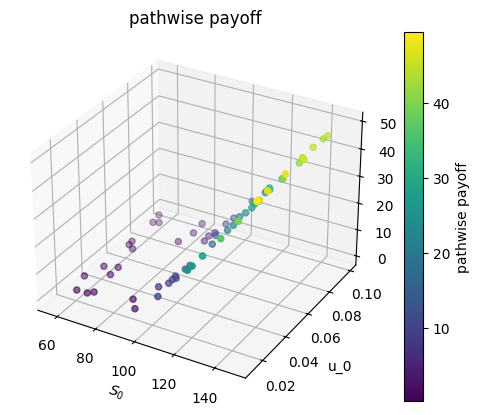

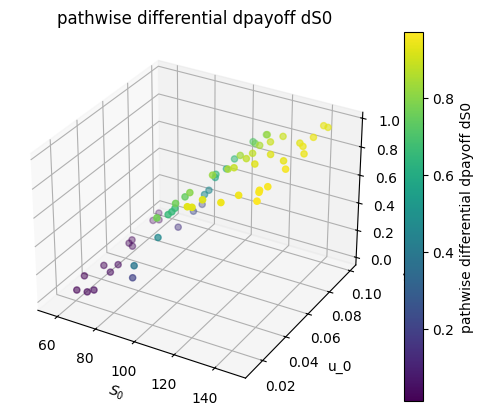

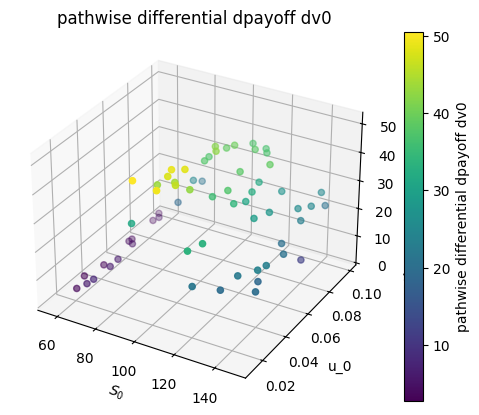

In [18]:
xs = test_set.initial_states[..., 0]
ys = test_set.initial_states[..., 1]

fig_payoff = plot_3d_differential_data(xs, ys, test_set.payoffs, "pathwise payoff")
fig_dS = plot_3d_differential_data(xs, ys, test_set.differentials[-2], "pathwise differential dpayoff dS0")
fig_dv = plot_3d_differential_data(xs, ys, test_set.differentials[-1], "pathwise differential dpayoff dv0")

In [ ]:
## TODO normalization?
#
#def testing_batch(spot_range, vol_range, hs_params, key, batch_size=256):
#
#    minvals=jnp.array([spot_range.minval, vol_range.minval])
#    maxvals=jnp.array([spot_range.maxval, vol_range.maxval])
#
#    key, key_state = jrandom.split(key)
#
#    initial_states = jnp.ones((batch_size, 2)) * jrandom.uniform(key_state, shape=(2,), minval=minvals, maxval=maxvals)
#    
#    initial_spots = initial_states[:, 0]
#    initial_vols = initial_states[:, 1]
#    
#    hs = Heston.from_parameters(hs_params, S0=initial_spots, v0=initial_vols)
#    
#    path_seeds = jrandom.split(key, batch_size)
#    ps, dps = eqx.filter_vmap(partial(differential_path, n_time_steps=1024))(hs, path_seeds)
#    
#
#    ## TODO implemnt this avg discount step
#    #def discounted_avg(x, h: Heston.Parameters):
#    #    return jnp.mean(x, axis=1) * jnp.exp(-h.r * h.T) 
#    #
#    #ps = discounted_avg(ps, h=hs_params)
#    #dps = [
#    #            discounted_avg(dps.S0, h=hs_params),
#    #            discounted_avg(dps.v0, h=hs_params)
#    #        ]
# 
#    return initial_states, ps, dps
#    #      x               y   dydx
#    
#    ##initial_states, ps, dps, ddps
#    ##x, y, dydx, ddy

(256,)
(256,)
(256,)
(256,)
(256,)


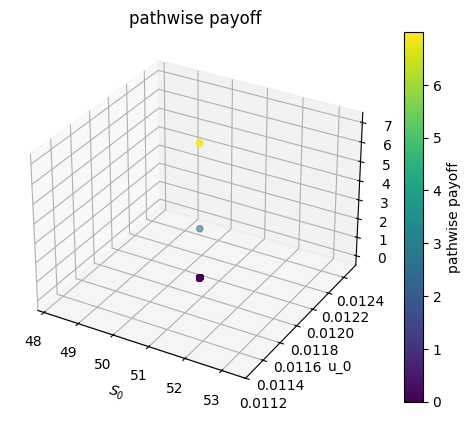

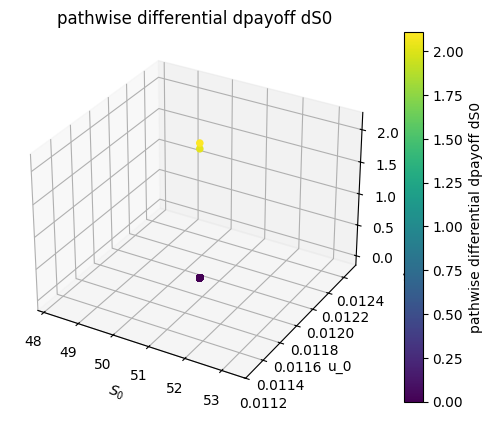

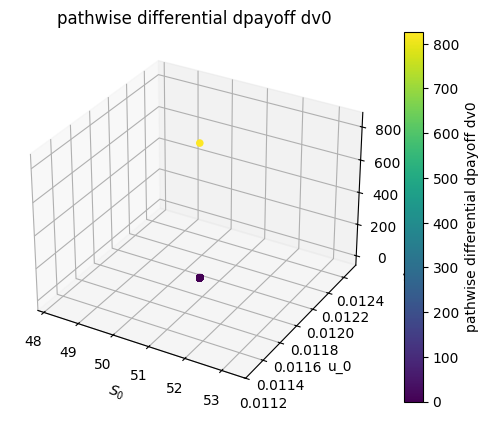

In [ ]:
#vis_batch = testing_batch(spot_range, vol_range, hs_params, key, batch_size=256)#8196)
#
#xs = vis_batch[0][..., 0]
#ys = vis_batch[0][..., 1]
#ps = vis_batch[1]
#dps = vis_batch[2]
#
#print(xs.shape)
#print(ys.shape)
#print(ps.shape)
#print(dps.S0.shape)
#print(dps.v0.shape)
#
#fig_payoff = plot_3d_differential_data(xs, ys, ps, "pathwise payoff")
#fig_dS = plot_3d_differential_data(xs, ys, dps.S0, "pathwise differential dpayoff dS0")
#fig_dv = plot_3d_differential_data(xs, ys, dps.v0, "pathwise differential dpayoff dv0")

In [19]:
# TODO normalize beforehand?

# eval price predictions
test_pred_ys, test_pred_dys = vmap(jax.value_and_grad(surrogate_model))(test_set.initial_states)
jnp.sqrt(mse(test_pred_ys, test_set.payoffs))

Array(8.109437, dtype=float32)

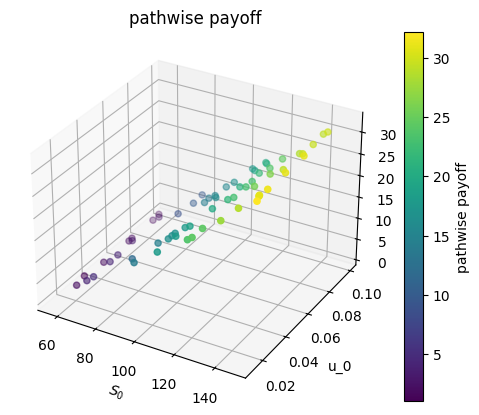

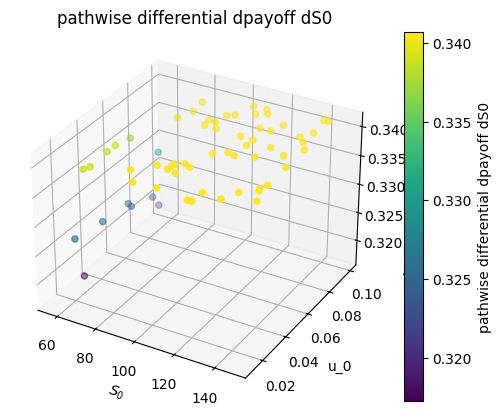

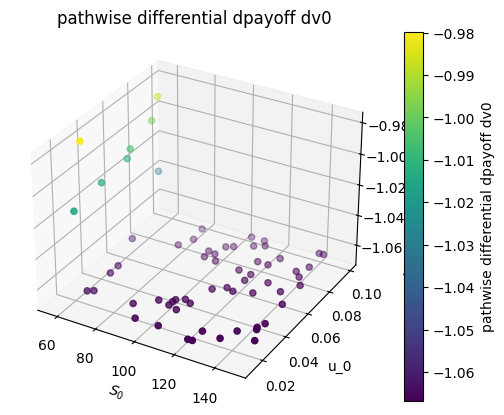

In [20]:
# plot the predictions
fig_payoff = plot_3d_differential_data(xs, ys, test_pred_ys, "pathwise payoff")
fig_dS = plot_3d_differential_data(xs, ys, test_pred_dys[:, 0], "pathwise differential dpayoff dS0")
fig_dv = plot_3d_differential_data(xs, ys, test_pred_dys[:, 1], "pathwise differential dpayoff dv0")